<a href="https://colab.research.google.com/github/intel-analytics/BigDL/blob/branch-2.0/python/nano/notebooks/hpo/seq_and_func.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

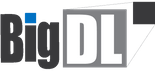

# Introduction
In this notebook we demonstrates how to use Nano HPO to tune the hyperparameters in tensorflow training. The model is built using either tensorflow keras sequential API or functional API.


# Step0: Prepare Environment
You can install the latest pre-release version with nano support using below commands.

We recommend to run below commands, especially `source bigdl-nano-init` before jupyter kernel is started, or some of the optimizations may not take effect.


In [2]:
# Install latest pre-release version of bigdl-nano
!pip install --pre bigdl-nano[tensorflow]
!pip install setuptools==58.0.4
!pip install protobuf==3.20.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 4.1 MB/s 
     |████████████████████████████████| 1.0 MB 42.2 MB/s 
     |████████████████████████████████| 463 kB 68.8 MB/s 
     |████████████████████████████████| 1.3 MB 46.6 MB/s 
     |████████████████████████████████| 186.3 MB 65 kB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 816 kB 2.9 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires keras<2.9,>=2.8.0rc0, but you have keras 2.7.0 which is incompatible.
tensorflow 2.8.2+zzzcolab20220527125636 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.
tensorflow 2.8.2+zzzcolab20220527125636 requires tensorflow-estimator<2.9,>=2.8, but you have tensorflow-estimator 2.7.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Install other dependecies for Nano HPO
!pip install ConfigSpace
!pip install optuna
exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 209 kB 61.5 MB/s 
     |████████████████████████████████| 81 kB 6.7 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 146 kB 51.5 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 112 kB 49.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=35b434aa719ed5ceb9fd9efe8234ce87a938aa6dea21cbf90e05a4bbca8d7b20
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
!source bigdl-nano-init

conda dir found: /usr/local/bin/..
OpenMP library found...
Setting OMP_NUM_THREADS...
Setting OMP_NUM_THREADS specified for pytorch...
Setting KMP_AFFINITY...
Setting KMP_BLOCKTIME...
Setting MALLOC_CONF...
Not in a conda env
+++++ Env Variables +++++
LD_PRELOAD=/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4
MALLOC_CONF=
OMP_NUM_THREADS=1
KMP_AFFINITY=granularity=fine,compact,1,0
KMP_BLOCKTIME=1
TF_ENABLE_ONEDNN_OPTS=1
ENABLE_TF_OPTS=1
NANO_TF_INTER_OP=1
+++++++++++++++++++++++++
Complete.


# Step1: Init Nano AutoML
We need to enable Nano HPO before we use it for tensorflow training.

In [5]:
import bigdl.nano.automl as automl
automl.hpo_config.enable_hpo_tf()

# Step2: Prepare data
We use MNIST dataset for demonstration.

In [6]:
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

CLASSES = 10
img_x, img_y = x_train.shape[1], x_train.shape[2]
input_shape = (img_x, img_y, 1)
x_train = x_train.reshape(-1, img_x, img_y,1).astype("float32") / 255
x_test = x_test.reshape(-1, img_x, img_y,1).astype("float32") / 255

11501568/11490434 [==============================] - 0s 0us/step


# Step3: Set search space

We now create our model. 

Change the imports from tensorflow.keras to bigdl.nano as below, and you will be able to specify search spaces as you define the model. For how to specify search space, refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html).

In [7]:
from bigdl.nano.automl.tf.keras import Sequential
from bigdl.nano.tf.keras.layers import Dense, Flatten, Conv2D
from bigdl.nano.tf.keras import Input
from bigdl.nano.automl.tf.keras import Model
import bigdl.nano.automl.hpo.space as space

Below two cells show how to define the model with search spaces using either sequential or functional API respectively. You can choose one of them to run.

In [8]:
model = Sequential()
model.add(Conv2D(
    filters=space.Categorical(32, 64),
    kernel_size=space.Categorical(3, 5),
    strides=space.Categorical(1, 2),
    activation=space.Categorical("relu", "linear"),
    input_shape=input_shape))
model.add(Flatten())
model.add(Dense(CLASSES, activation="softmax"))

In [ ]:
inputs = Input(shape=(28,28,1))
x = Conv2D(
    filters=space.Categorical(32, 64),
    kernel_size=space.Categorical(3, 5),
    strides=space.Categorical(1, 2),
    activation=space.Categorical("relu", "linear"),
    input_shape=input_shape)(inputs)
x = Flatten()(x)
outputs = Dense(CLASSES, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs, name="mnist_model")

# Step4: Compile model
We now compile our model with loss function, optimizer and metrics.

In [9]:
from tensorflow.keras.optimizers import RMSprop
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=RMSprop(learning_rate=0.001),
    metrics=["accuracy"]
)

# Step5: Run hyperparameter search
Run hyperparameter search by calling `model.search`. Set `n_trials` to the number of trialials you want to run, and set the `target_metric` and `direction` so that HPO optimizes the `target_metric` in the specified `direction`. Each trial will use a different set of hyperparameters in the search space range. Use `n_parallels` to set the nubmer of parallel processes to run trials. After search completes, you can use `search_summary` to retrive the search results for analysis. For more details, refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html)

In [10]:
%%time
from bigdl.nano.automl.hpo.backend import PrunerType
model.search(
    n_trials=8,
    target_metric='val_accuracy',
    direction="maximize",
    pruner=PrunerType.HyperBand,
    pruner_kwargs={'min_resource':1, 'max_resource':100, 'reduction_factor':3},
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.2,
    verbose=False
)

[I 2022-06-07 14:22:46,742] A new study created in memory with name: no-name-8a2b9e7f-9017-413f-ab2b-6e5f3f50fc26


Starting a new tuning
Epoch 1/5
375/375 - 11s - loss: 0.2878 - accuracy: 0.9170 - val_loss: 0.1418 - val_accuracy: 0.9631 - 11s/epoch - 29ms/step
Epoch 2/5
375/375 - 10s - loss: 0.1089 - accuracy: 0.9695 - val_loss: 0.0945 - val_accuracy: 0.9748 - 10s/epoch - 27ms/step
Epoch 3/5
375/375 - 11s - loss: 0.0755 - accuracy: 0.9778 - val_loss: 0.0833 - val_accuracy: 0.9766 - 11s/epoch - 30ms/step
Epoch 4/5
375/375 - 13s - loss: 0.0604 - accuracy: 0.9829 - val_loss: 0.0758 - val_accuracy: 0.9789 - 13s/epoch - 36ms/step
Epoch 5/5
375/375 - 10s - loss: 0.0516 - accuracy: 0.9854 - val_loss: 0.0742 - val_accuracy: 0.9797 - 10s/epoch - 27ms/step


[I 2022-06-07 14:23:42,789] Trial 0 finished with value: 0.9797499775886536 and parameters: {'activation▁choice': 0, 'filters▁choice': 0, 'kernel_size▁choice': 0, 'strides▁choice': 0}. Best is trial 0 with value: 0.9797499775886536.


Epoch 1/5
375/375 - 5s - loss: 0.3915 - accuracy: 0.8874 - val_loss: 0.3001 - val_accuracy: 0.9162 - 5s/epoch - 13ms/step
Epoch 2/5
375/375 - 5s - loss: 0.3116 - accuracy: 0.9115 - val_loss: 0.2852 - val_accuracy: 0.9208 - 5s/epoch - 13ms/step
Epoch 3/5
375/375 - 5s - loss: 0.2986 - accuracy: 0.9170 - val_loss: 0.2837 - val_accuracy: 0.9217 - 5s/epoch - 14ms/step
Epoch 4/5
375/375 - 5s - loss: 0.2907 - accuracy: 0.9172 - val_loss: 0.2818 - val_accuracy: 0.9247 - 5s/epoch - 14ms/step
Epoch 5/5
375/375 - 5s - loss: 0.2846 - accuracy: 0.9204 - val_loss: 0.2876 - val_accuracy: 0.9199 - 5s/epoch - 13ms/step


[I 2022-06-07 14:24:08,130] Trial 1 finished with value: 0.9247499704360962 and parameters: {'activation▁choice': 1, 'filters▁choice': 1, 'kernel_size▁choice': 1, 'strides▁choice': 1}. Best is trial 0 with value: 0.9797499775886536.


Epoch 1/5
375/375 - 3s - loss: 0.4104 - accuracy: 0.8831 - val_loss: 0.3163 - val_accuracy: 0.9102 - 3s/epoch - 9ms/step
Epoch 2/5


[I 2022-06-07 14:24:14,811] Trial 2 pruned. Trial was pruned at epoch 1.


Epoch 1/5
375/375 - 4s - loss: 0.3820 - accuracy: 0.8932 - val_loss: 0.1962 - val_accuracy: 0.9488 - 4s/epoch - 12ms/step
Epoch 2/5
375/375 - 4s - loss: 0.1599 - accuracy: 0.9545 - val_loss: 0.1181 - val_accuracy: 0.9710 - 4s/epoch - 12ms/step
Epoch 3/5
375/375 - 3s - loss: 0.1017 - accuracy: 0.9714 - val_loss: 0.0928 - val_accuracy: 0.9737 - 3s/epoch - 8ms/step
Epoch 4/5
375/375 - 3s - loss: 0.0780 - accuracy: 0.9783 - val_loss: 0.0773 - val_accuracy: 0.9793 - 3s/epoch - 8ms/step
Epoch 5/5
375/375 - 3s - loss: 0.0644 - accuracy: 0.9815 - val_loss: 0.0782 - val_accuracy: 0.9784 - 3s/epoch - 9ms/step


[I 2022-06-07 14:24:37,531] Trial 3 finished with value: 0.9792500138282776 and parameters: {'activation▁choice': 0, 'filters▁choice': 0, 'kernel_size▁choice': 1, 'strides▁choice': 1}. Best is trial 0 with value: 0.9797499775886536.


Epoch 1/5
375/375 - 20s - loss: 0.1962 - accuracy: 0.9421 - val_loss: 0.0779 - val_accuracy: 0.9787 - 20s/epoch - 53ms/step
Epoch 2/5
375/375 - 19s - loss: 0.0661 - accuracy: 0.9802 - val_loss: 0.0660 - val_accuracy: 0.9809 - 19s/epoch - 52ms/step
Epoch 3/5
375/375 - 19s - loss: 0.0465 - accuracy: 0.9861 - val_loss: 0.0602 - val_accuracy: 0.9833 - 19s/epoch - 52ms/step
Epoch 4/5
375/375 - 21s - loss: 0.0360 - accuracy: 0.9893 - val_loss: 0.0573 - val_accuracy: 0.9837 - 21s/epoch - 55ms/step
Epoch 5/5
375/375 - 20s - loss: 0.0285 - accuracy: 0.9916 - val_loss: 0.0640 - val_accuracy: 0.9824 - 20s/epoch - 52ms/step


[I 2022-06-07 14:26:16,589] Trial 4 finished with value: 0.9836666584014893 and parameters: {'activation▁choice': 0, 'filters▁choice': 1, 'kernel_size▁choice': 1, 'strides▁choice': 0}. Best is trial 4 with value: 0.9836666584014893.


Epoch 1/5
375/375 - 6s - loss: 0.3821 - accuracy: 0.8938 - val_loss: 0.2159 - val_accuracy: 0.9414 - 6s/epoch - 16ms/step
Epoch 2/5
375/375 - 6s - loss: 0.1775 - accuracy: 0.9504 - val_loss: 0.1333 - val_accuracy: 0.9639 - 6s/epoch - 15ms/step
Epoch 3/5
375/375 - 5s - loss: 0.1140 - accuracy: 0.9675 - val_loss: 0.1039 - val_accuracy: 0.9715 - 5s/epoch - 14ms/step
Epoch 4/5


[I 2022-06-07 14:26:40,178] Trial 5 pruned. Trial was pruned at epoch 3.


Epoch 1/5
375/375 - 6s - loss: 0.3970 - accuracy: 0.8878 - val_loss: 0.2906 - val_accuracy: 0.9162 - 6s/epoch - 17ms/step
Epoch 2/5


[I 2022-06-07 14:26:52,830] Trial 6 pruned. Trial was pruned at epoch 1.


Epoch 1/5
375/375 - 6s - loss: 0.3722 - accuracy: 0.8963 - val_loss: 0.2113 - val_accuracy: 0.9414 - 6s/epoch - 16ms/step
Epoch 2/5
375/375 - 6s - loss: 0.1793 - accuracy: 0.9494 - val_loss: 0.1350 - val_accuracy: 0.9628 - 6s/epoch - 16ms/step
Epoch 3/5
375/375 - 6s - loss: 0.1182 - accuracy: 0.9669 - val_loss: 0.1079 - val_accuracy: 0.9713 - 6s/epoch - 16ms/step
Epoch 4/5
375/375 - 5s - loss: 0.0914 - accuracy: 0.9739 - val_loss: 0.0968 - val_accuracy: 0.9730 - 5s/epoch - 14ms/step
Epoch 5/5
375/375 - 5s - loss: 0.0764 - accuracy: 0.9778 - val_loss: 0.0852 - val_accuracy: 0.9770 - 5s/epoch - 14ms/step


[I 2022-06-07 14:27:42,622] Trial 7 finished with value: 0.9769999980926514 and parameters: {'activation▁choice': 0, 'filters▁choice': 1, 'kernel_size▁choice': 0, 'strides▁choice': 1}. Best is trial 4 with value: 0.9836666584014893.


CPU times: user 6min 20s, sys: 2min 13s, total: 8min 33s
Wall time: 4min 55s


In [11]:
print(model.search_summary())

Number of finished trials: 8
Best trial:
  Value: 0.9836666584014893
  Params: 
    activation▁choice: 0
    filters▁choice: 1
    kernel_size▁choice: 1
    strides▁choice: 0


# Step6: (Optional) Resume training from memory
You can resume the previous search when a search completes by setting `resume=True`. Refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html) for more details.

In [12]:
%%time
model.search(
    n_trials=4,
    target_metric='val_accuracy',
    direction="maximize",
    pruner=PrunerType.HyperBand,
    pruner_kwargs={'min_resource':1, 'max_resource':100, 'reduction_factor':3},
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.2,
    verbose=False,
    resume = True
)

Epoch 1/5
375/375 - 18s - loss: 0.3845 - accuracy: 0.8881 - val_loss: 0.3097 - val_accuracy: 0.9142 - 18s/epoch - 48ms/step
Epoch 2/5
375/375 - 17s - loss: 0.3175 - accuracy: 0.9114 - val_loss: 0.2984 - val_accuracy: 0.9162 - 17s/epoch - 46ms/step
Epoch 3/5
375/375 - 17s - loss: 0.3003 - accuracy: 0.9154 - val_loss: 0.2879 - val_accuracy: 0.9205 - 17s/epoch - 46ms/step
Epoch 4/5


[I 2022-06-07 14:28:52,795] Trial 8 pruned. Trial was pruned at epoch 3.


Epoch 1/5
375/375 - 4s - loss: 0.4122 - accuracy: 0.8838 - val_loss: 0.2973 - val_accuracy: 0.9153 - 4s/epoch - 10ms/step
Epoch 2/5


[I 2022-06-07 14:28:59,671] Trial 9 pruned. Trial was pruned at epoch 1.


Epoch 1/5
375/375 - 11s - loss: 0.2949 - accuracy: 0.9156 - val_loss: 0.1457 - val_accuracy: 0.9599 - 11s/epoch - 30ms/step
Epoch 2/5
375/375 - 10s - loss: 0.1088 - accuracy: 0.9691 - val_loss: 0.0901 - val_accuracy: 0.9762 - 10s/epoch - 27ms/step
Epoch 3/5
375/375 - 11s - loss: 0.0730 - accuracy: 0.9792 - val_loss: 0.0757 - val_accuracy: 0.9787 - 11s/epoch - 28ms/step
Epoch 4/5
375/375 - 11s - loss: 0.0571 - accuracy: 0.9837 - val_loss: 0.0751 - val_accuracy: 0.9790 - 11s/epoch - 28ms/step
Epoch 5/5
375/375 - 10s - loss: 0.0488 - accuracy: 0.9866 - val_loss: 0.0740 - val_accuracy: 0.9788 - 10s/epoch - 26ms/step


[I 2022-06-07 14:29:52,022] Trial 10 finished with value: 0.9789999723434448 and parameters: {'activation▁choice': 0, 'filters▁choice': 0, 'kernel_size▁choice': 0, 'strides▁choice': 0}. Best is trial 4 with value: 0.9836666584014893.


Epoch 1/5
375/375 - 7s - loss: 0.3038 - accuracy: 0.9132 - val_loss: 0.1315 - val_accuracy: 0.9656 - 7s/epoch - 17ms/step
Epoch 2/5
375/375 - 6s - loss: 0.1082 - accuracy: 0.9689 - val_loss: 0.0885 - val_accuracy: 0.9758 - 6s/epoch - 17ms/step
Epoch 3/5
375/375 - 6s - loss: 0.0745 - accuracy: 0.9785 - val_loss: 0.0739 - val_accuracy: 0.9784 - 6s/epoch - 16ms/step
Epoch 4/5
375/375 - 6s - loss: 0.0594 - accuracy: 0.9824 - val_loss: 0.0689 - val_accuracy: 0.9808 - 6s/epoch - 16ms/step
Epoch 5/5
375/375 - 6s - loss: 0.0490 - accuracy: 0.9860 - val_loss: 0.0623 - val_accuracy: 0.9822 - 6s/epoch - 17ms/step


[I 2022-06-07 14:30:23,321] Trial 11 finished with value: 0.9821666479110718 and parameters: {'activation▁choice': 0, 'filters▁choice': 1, 'kernel_size▁choice': 1, 'strides▁choice': 1}. Best is trial 4 with value: 0.9836666584014893.


CPU times: user 3min 50s, sys: 1min 22s, total: 5min 12s
Wall time: 2min 40s


In [13]:
print(model.search_summary())

Number of finished trials: 12
Best trial:
  Value: 0.9836666584014893
  Params: 
    activation▁choice: 0
    filters▁choice: 1
    kernel_size▁choice: 1
    strides▁choice: 0


# Step 7: fit with the best hyperparameters
After search, `model.fit` will autotmatically use the best hyperparmeters found in search to fit the model.

In [14]:
history = model.fit(x_train, y_train,
                    batch_size=128, epochs=5, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/5
375/375 [==============================] - 23s 60ms/step - loss: 0.1978 - accuracy: 0.9407 - val_loss: 0.0845 - val_accuracy: 0.9747
Epoch 2/5
375/375 [==============================] - 23s 60ms/step - loss: 0.0677 - accuracy: 0.9798 - val_loss: 0.0617 - val_accuracy: 0.9821
Epoch 3/5
375/375 [==============================] - 24s 64ms/step - loss: 0.0473 - accuracy: 0.9863 - val_loss: 0.0603 - val_accuracy: 0.9837
Epoch 4/5
375/375 [==============================] - 23s 60ms/step - loss: 0.0371 - accuracy: 0.9890 - val_loss: 0.0564 - val_accuracy: 0.9839
Epoch 5/5
375/375 [==============================] - 22s 59ms/step - loss: 0.0299 - accuracy: 0.9912 - val_loss: 0.0670 - val_accuracy: 0.9819
313/313 - 2s - loss: 0.0526 - accuracy: 0.9835 - 2s/epoch - 8ms/step
Test loss: 0.052601225674152374
Test accuracy: 0.9835000038146973


# Step 8: HPO Result Analysis and Visualization
Check out the summary of the model. The model has already been built with the best hyperparameters found by nano hpo.

In [15]:
print(model.summary())
study = model.search_summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        1664      
                                                                 
 flatten_1 (Flatten)         (None, 36864)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                368650    
                                                                 
Total params: 370,314
Trainable params: 370,314
Non-trainable params: 0
_________________________________________________________________
None
Number of finished trials: 12
Best trial:
  Value: 0.9836666584014893
  Params: 
    activation▁choice: 0
    filters▁choice: 1
    kernel_size▁choice: 1
    strides▁choice: 0


In [16]:
study.trials_dataframe(attrs=("number", "value", "params", "state"))

,number,value,params_activation▁choice,params_filters▁choice,params_kernel_size▁choice,params_strides▁choice,state
0,0,0.979750,0,0,0,0,COMPLETE
1,1,0.924750,1,1,1,1,COMPLETE
2,2,0.918750,1,0,1,1,PRUNED
3,3,0.979250,0,0,1,1,COMPLETE
4,4,0.983667,0,1,1,0,COMPLETE
5,5,0.973917,0,1,0,1,PRUNED
6,6,0.919917,1,1,0,1,PRUNED
7,7,0.977000,0,1,0,1,COMPLETE
8,8,0.921917,1,1,1,0,PRUNED
9,9,0.921000,1,0,1,1,PRUNED


In [17]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

In [18]:
from optuna.visualization import plot_parallel_coordinate
plot_parallel_coordinate(study)

In [19]:
from optuna.visualization import plot_intermediate_values
plot_intermediate_values(study)

In [20]:
from optuna.visualization import plot_contour
plot_contour(study)

In [21]:
from optuna.visualization import plot_param_importances
plot_param_importances(study)

In [22]:
plot_param_importances(study, target=lambda t: t.duration.total_seconds(), target_name="duration")